<table style="width:100%">
<tr>
<td style="vertical-align:middle; text-align:left;">
<font size="2">
<a href="http://mng.bz/orYv">从零开始构建大型语言模型</a> 一书的补充代码，作者：<a href="https://sebastianraschka.com">Sebastian Raschka</a><br>
<br>代码仓库：<a href="https://github.com/rasbt/LLMs-from-scratch">https://github.com/rasbt/LLMs-from-scratch</a>
</font>
</td>
<td style="vertical-align:middle; text-align:left;">
<a href="http://mng.bz/orYv"><img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/cover-small.webp" width="100px"></a>
</td>
</tr>
</table>

# 第4章：从零开始实现GPT模型以生成文本

In [65]:
from importlib.metadata import version

print("matplotlib version:", version("matplotlib"))
print("torch version:", version("torch"))
print("tiktoken version:", version("tiktoken"))

matplotlib version: 3.10.5
torch version: 2.7.1
tiktoken version: 0.9.0


- 在本章中，我们实现一个类似GPT的LLM架构；下一章将专注于训练这个LLM

<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch04_compressed/01.webp" width="500px">

## 4.1 编码LLM架构

- 第1章讨论了像GPT和Llama这样的模型，它们按顺序生成单词，基于原始transformer架构的解码器部分
- 因此，这些LLM通常被称为\"类解码器\"LLM
- 与传统的深度学习模型相比，LLM更大，主要是由于它们的大量参数，而不是代码量
- 我们将看到LLM架构中有许多重复的元素

<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch04_compressed/02.webp" width="400px">

- 在前面的章节中，我们为了便于说明使用了较小的token输入和输出嵌入维度，确保它们能在单页上显示
- 在本章中，我们考虑类似于小型GPT-2模型的嵌入和模型大小
- 我们将专门编码最小的GPT-2模型（1.24亿参数）的架构，如Radford等人的[Language Models are Unsupervised Multitask Learners](https://cdn.openai.com/better-language-models/language_models_are_unsupervised_multitask_learners.pdf)中所述（注意初始报告将其列为117M参数，但这在模型权重仓库中后来得到了纠正）
- 第6章将展示如何将预训练权重加载到我们的实现中，这将与3.45亿、7.62亿和15.42亿参数的模型大小兼容

- 1.24亿参数GPT-2模型的配置详情包括：

In [66]:
GPT_CONFIG_124M = {
    "vocab_size": 50257,    # 词汇表大小
    "context_length": 1024, # 上下文长度
    "emb_dim": 768,         # 嵌入维度
    "n_heads": 12,          # 注意力头数量
    "n_layers": 12,         # 层数
    "drop_rate": 0.1,       # Dropout率
    "qkv_bias": False       # 查询-键-值偏置
}

- 我们使用简短的变量名以避免后面代码行过长
- `"vocab_size"` 表示词汇表大小为50,257个单词，由第2章讨论的BPE分词器支持
- `"context_length"` 表示模型的最大输入token数量，由第2章涵盖的位置嵌入启用
- `"emb_dim"` 是token输入的嵌入大小，将每个输入token转换为768维向量
- `"n_heads"` 是第3章实现的多头注意力机制中的注意力头数量
- `"n_layers"` 是模型内transformer块的数量，我们将在接下来的部分中实现
- `"drop_rate"` 是dropout机制的强度，在第3章中讨论；0.1意味着在训练期间丢弃10%的隐藏单元以减轻过拟合
- `"qkv_bias"` 决定多头注意力机制中的 `Linear` 层（来自第3章）在计算查询(Q)、键(K)和值(V)张量时是否应包含偏置向量；我们将禁用此选项，这是现代LLM的标准做法；但是，当我们在第5章将OpenAI的预训练GPT-2权重加载到我们的重新实现中时，我们将重新讨论这一点

<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch04_compressed/03.webp" width="500px">

In [67]:
import torch
import torch.nn as nn


class DummyGPTModel(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.tok_emb = nn.Embedding(cfg["vocab_size"], cfg["emb_dim"])
        self.pos_emb = nn.Embedding(cfg["context_length"], cfg["emb_dim"])
        self.drop_emb = nn.Dropout(cfg["drop_rate"])
        
        # 使用TransformerBlock的占位符
        self.trf_blocks = nn.Sequential(
            *[DummyTransformerBlock(cfg) for _ in range(cfg["n_layers"])])
        
        # 使用LayerNorm的占位符
        self.final_norm = DummyLayerNorm(cfg["emb_dim"])
        self.out_head = nn.Linear(
            cfg["emb_dim"], cfg["vocab_size"], bias=False
        )

    def forward(self, in_idx):
        batch_size, seq_len = in_idx.shape
        tok_embeds = self.tok_emb(in_idx)
        pos_embeds = self.pos_emb(torch.arange(seq_len, device=in_idx.device))
        x = tok_embeds + pos_embeds
        x = self.drop_emb(x)
        x = self.trf_blocks(x)
        x = self.final_norm(x)
        logits = self.out_head(x)
        return logits


class DummyTransformerBlock(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        # 一个简单的占位符

    def forward(self, x):
        # 一个简单的占位符
        return x


class DummyLayerNorm(nn.Module):
    def __init__(self, normalized_shape, eps=1e-5):
        super().__init__()
        # 一个简单的占位符

    def forward(self, x):
        # 一个简单的占位符
        return x

- 上面的代码定义了一个占位符GPT模型架构，其中包含token和位置嵌入层、dropout、transformer块、层归一化和线性输出层
- 我们将在接下来的部分中用实际实现替换占位符类

In [68]:
import tiktoken

tokenizer = tiktoken.get_encoding("gpt2")

batch = []
txt1 = "Every effort moves you"
txt2 = "Every day holds a"

batch.append(torch.tensor(tokenizer.encode(txt1)))
batch.append(torch.tensor(tokenizer.encode(txt2)))
batch = torch.stack(batch, dim=0)
print("输入形状:", batch.shape)

model = DummyGPTModel(GPT_CONFIG_124M)
logits = model(batch)
print("输出形状:", logits.shape)

输入形状: torch.Size([2, 4])
输出形状: torch.Size([2, 4, 50257])


- 输出张量的形状是 `[batch_size, num_tokens, vocab_size]`
- 这意味着对于批次中的每个输入token，模型输出一个50,257维的向量（对应于词汇表中的每个token）
- 接下来，我们将实现各个组件以创建一个功能完整的GPT模型

---

**注意**

- 如果您在Windows或Linux上运行此代码，上面的结果值可能如下所示：
    
```
Output shape: torch.Size([2, 4, 50257])
tensor([[[-0.9289,  0.2748, -0.7557,  ..., -1.6070,  0.2702, -0.5888],
         [-0.4476,  0.1726,  0.5354,  ..., -0.3932,  1.5285,  0.8557],
         [ 0.5680,  1.6053, -0.2155,  ...,  1.1624,  0.1380,  0.7425],
         [ 0.0447,  2.4787, -0.8843,  ...,  1.3219, -0.0864, -0.5856]],

        [[-1.5474, -0.0542, -1.0571,  ..., -1.8061, -0.4494, -0.6747],
         [-0.8422,  0.8243, -0.1098,  ..., -0.1434,  0.2079,  1.2046],
         [ 0.1355,  1.1858, -0.1453,  ...,  0.0869, -0.1590,  0.1552],
         [ 0.1666, -0.8138,  0.2307,  ...,  2.5035, -0.3055, -0.3083]]],
       grad_fn=<UnsafeViewBackward0>)
```

- 由于这些只是随机数，这不是令人担心的原因，您可以继续本章的其余部分而不会有问题
- 造成这种差异的一个可能原因是 `nn.Dropout` 在不同操作系统上的行为不同，这取决于PyTorch的编译方式，如[PyTorch问题跟踪器](https://github.com/pytorch/pytorch/issues/121595)中所讨论的

---

## 4.2 使用层归一化规范化激活

- 层归一化，也称为LayerNorm（[Ba等人，2016](https://arxiv.org/abs/1607.06450)），将神经网络层的激活以0为中心，并将其方差归一化为1
- 这稳定了训练并使其能够更快地收敛到有效权重
- 层归一化在transformer块内的多头注意力模块之前和之后都会应用，我们稍后会实现；它也在最终输出层之前应用

<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch04_compressed/05.webp" width="400px">

- 让我们实现层归一化，从一个简单的例子开始：

In [69]:
torch.manual_seed(123)

# 创建2个样本，每个有5个维度（特征）
batch_example = torch.randn(2, 5) 
print(batch_example.shape)

torch.Size([2, 5])


In [70]:
print(batch_example)

tensor([[-0.1115,  0.1204, -0.3696, -0.2404, -1.1969],
        [ 0.2093, -0.9724, -0.7550,  0.3239, -0.1085]])


- 层归一化通常在最后一个维度上应用，这对应于嵌入维度
- 这意味着我们计算每个样本（行）的均值和方差：

In [71]:
layer = batch_example[0]  # 第一个样本

mean = batch_example.mean(dim=-1, keepdim=True)
var = batch_example.var(dim=-1, keepdim=True)

print("均值:", mean)
print("方差:", var)

均值: tensor([[-0.3596],
        [-0.2606]])
方差: tensor([[0.2518],
        [0.3342]])


- 现在让我们应用层归一化：

In [72]:
out_norm = (batch_example - mean) / torch.sqrt(var + 1e-5)
print("归一化后:\n", out_norm)

归一化后:
 tensor([[ 0.4945,  0.9564, -0.0200,  0.2375, -1.6685],
        [ 0.8127, -1.2313, -0.8554,  1.0110,  0.2630]])


- 让我们验证归一化后的输出确实具有0均值和1方差：

In [73]:
mean = out_norm.mean(dim=-1, keepdim=True)
var = out_norm.var(dim=-1, keepdim=True)

print("归一化后的均值:", mean.flatten())
print("归一化后的方差:", var.flatten())

归一化后的均值: tensor([-1.4901e-08,  2.3842e-08])
归一化后的方差: tensor([1.0000, 1.0000])


- 现在让我们实现一个LayerNorm类：

In [74]:
class LayerNorm(nn.Module):
    def __init__(self, emb_dim):
        super().__init__()
        self.eps = 1e-5
        self.scale = nn.Parameter(torch.ones(emb_dim))
        self.shift = nn.Parameter(torch.zeros(emb_dim))

    def forward(self, x):
        mean = x.mean(dim=-1, keepdim=True)
        var = x.var(dim=-1, keepdim=True, unbiased=False)
        norm_x = (x - mean) / torch.sqrt(var + self.eps)
        return self.scale * norm_x + self.shift

- `scale` 和 `shift` 是可学习的参数，允许模型学习适当的缩放和偏移
- 归一化应用于每个输入（行）独立地；使用dim=-1在最后一个维度（在这种情况下是特征维度）而不是行维度上应用计算

In [75]:
ln = LayerNorm(emb_dim=5)
out_ln = ln(batch_example)
print(out_ln)

tensor([[ 0.5528,  1.0693, -0.0223,  0.2656, -1.8654],
        [ 0.9087, -1.3767, -0.9564,  1.1304,  0.2940]], grad_fn=<AddBackward0>)


- 让我们验证我们的LayerNorm实现与PyTorch的内置实现产生相同的结果：

In [76]:
torch.manual_seed(123)
batch_example = torch.randn(2, 5)

ln = LayerNorm(emb_dim=5)
out_ln = ln(batch_example)

# PyTorch的内置LayerNorm
ln_pytorch = nn.LayerNorm(5)
out_ln_pytorch = ln_pytorch(batch_example)

print("我们的实现:", out_ln)
print("PyTorch实现:", out_ln_pytorch)

我们的实现: tensor([[ 0.5528,  1.0693, -0.0223,  0.2656, -1.8654],
        [ 0.9087, -1.3767, -0.9564,  1.1304,  0.2940]], grad_fn=<AddBackward0>)
PyTorch实现: tensor([[ 0.5528,  1.0693, -0.0223,  0.2656, -1.8654],
        [ 0.9087, -1.3767, -0.9564,  1.1304,  0.2940]],
       grad_fn=<NativeLayerNormBackward0>)


**缩放和偏移**

- 注意，除了通过减去均值和除以方差来执行归一化之外，我们还添加了两个可训练参数，一个 `scale` 和一个 `shift` 参数
- 初始的 `scale`（乘以1）和 `shift`（加0）值没有任何效果；但是，`scale` 和 `shift` 是可训练参数，如果确定这样做会提高模型在训练任务上的性能，LLM会在训练期间自动调整它们
- 这允许模型学习最适合其处理数据的适当缩放和偏移
- 注意我们还在计算方差的平方根之前添加了一个较小的值（`eps`）；这是为了避免在方差为0时出现除零错误

**有偏方差**
- 在上面的方差计算中，设置 `unbiased=False` 意味着使用公式 $\frac{\sum_i (x_i - \bar{x})^2}{n}$ 来计算方差，其中n是样本大小（这里是特征或列的数量）；这个公式不包括贝塞尔校正（在分母中使用 `n-1`），因此提供了方差的有偏估计
- 对于LLM，其中嵌入维度 `n` 非常大，使用n和 `n-1` 之间的差异是可以忽略的
- 但是，GPT-2在归一化层中使用有偏方差进行训练，这就是为什么我们也采用这种设置以与我们将在后续章节中加载的预训练权重兼容的原因

## 4.3 使用GELU激活函数实现前馈网络

- 在本节中，我们实现一个小的神经网络子模块，用作transformer块中的前馈网络
- 这个前馈网络由两个 `Linear` 层和一个GELU激活函数组成

<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch04_compressed/07.webp" width="400px">

- GELU（高斯误差线性单元）激活函数是ReLU函数的平滑版本
- 与ReLU不同，ReLU在零处有一个尖锐的角，GELU是一个平滑的、可微分的曲线
- 让我们比较GELU和ReLU激活函数：

C:\Users\cruld\AppData\Local\Temp\ipykernel_8704\3488672341.py:19: UserWarning: Glyph 28608 (\N{CJK UNIFIED IDEOGRAPH-6FC0}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\cruld\AppData\Local\Temp\ipykernel_8704\3488672341.py:19: UserWarning: Glyph 27963 (\N{CJK UNIFIED IDEOGRAPH-6D3B}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\cruld\AppData\Local\Temp\ipykernel_8704\3488672341.py:19: UserWarning: Glyph 20989 (\N{CJK UNIFIED IDEOGRAPH-51FD}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\cruld\AppData\Local\Temp\ipykernel_8704\3488672341.py:19: UserWarning: Glyph 25968 (\N{CJK UNIFIED IDEOGRAPH-6570}) missing from font(s) DejaVu Sans.
  plt.tight_layout()


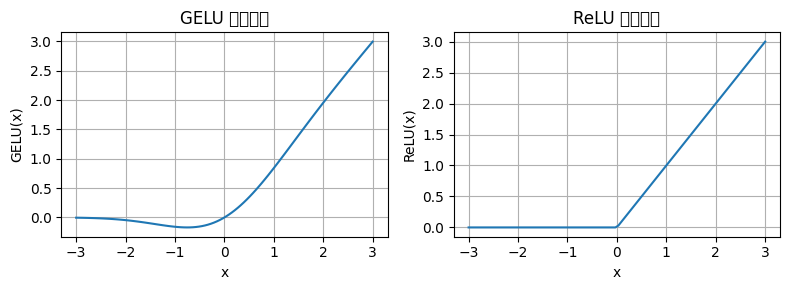

In [77]:
import matplotlib.pyplot as plt

# GELU和ReLU激活函数
gelu, relu = nn.GELU(), nn.ReLU()

# 一些示例数据
x = torch.linspace(-3, 3, 100)
y_gelu, y_relu = gelu(x), relu(x)

plt.figure(figsize=(8, 3))
for i, (y, label) in enumerate(zip([y_gelu, y_relu], ["GELU", "ReLU"]), 1):
    plt.subplot(1, 2, i)
    plt.plot(x, y)
    plt.title(f"{label} 激活函数")
    plt.xlabel("x")
    plt.ylabel(f"{label}(x)")
    plt.grid(True)

plt.tight_layout()
plt.show()

- 如我们所见，ReLU是一个分段线性函数，如果输入为正则直接输出输入；否则输出零
- GELU是一个平滑的非线性函数，近似于ReLU，但对负值有非零梯度（除了大约-0.75处）

- 接下来，让我们实现小型神经网络模块 `FeedForward`，我们稍后将在LLM的transformer块中使用它：

In [78]:
class FeedForward(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(cfg["emb_dim"], 4 * cfg["emb_dim"]),
            nn.GELU(),
            nn.Linear(4 * cfg["emb_dim"], cfg["emb_dim"]),
        )

    def forward(self, x):
        return self.layers(x)

- `FeedForward` 模块是一个小型神经网络，包含两个 `Linear` 层和一个GELU激活函数
- 第一个线性层将输入从 `emb_dim` 扩展到 `4 * emb_dim` 维度
- 第二个线性层将其投影回原始的 `emb_dim` 维度
- 这种扩展然后收缩的模式在transformer架构中很常见

<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch04_compressed/09.webp?12" width="400px">

In [79]:
print(GPT_CONFIG_124M["emb_dim"])

768


In [80]:
ffn = FeedForward(GPT_CONFIG_124M)

# 输入形状：[batch_size, num_token, emb_size]
x = torch.rand(2, 3, 768)
out = ffn(x)
print("输入形状:", x.shape)
print("输出形状:", out.shape)

输入形状: torch.Size([2, 3, 768])
输出形状: torch.Size([2, 3, 768])


- 如我们所见，前馈网络保持输入的形状，这对于在transformer块中使用很重要

<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch04_compressed/10.webp" width="400px">

<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch04_compressed/11.webp" width="400px">

## 4.4 添加快捷连接

- 接下来，让我们讨论快捷连接背后的概念，也称为跳跃连接或残差连接
- 最初，快捷连接是在计算机视觉的深度网络（残差网络）中提出的，用于缓解梯度消失问题
- 快捷连接为梯度在网络中流动创建了一条替代的更短路径
- 这是通过将一层的输出添加到后面一层的输出来实现的，通常跳过中间的一层或多层
- 让我们用一个小的示例网络来说明这个想法：

<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch04_compressed/12.webp?123" width="400px">

- 在代码中，它看起来像这样：

In [81]:
class ExampleDeepNeuralNetwork(nn.Module):
    def __init__(self, layer_sizes, use_shortcut):
        super().__init__()
        self.use_shortcut = use_shortcut
        self.layers = nn.ModuleList([
            nn.Sequential(nn.Linear(layer_sizes[0], layer_sizes[1]), nn.GELU()),
            nn.Sequential(nn.Linear(layer_sizes[1], layer_sizes[2]), nn.GELU()),
            nn.Sequential(nn.Linear(layer_sizes[2], layer_sizes[3]), nn.GELU()),
            nn.Sequential(nn.Linear(layer_sizes[3], layer_sizes[4]), nn.GELU()),
            nn.Sequential(nn.Linear(layer_sizes[4], layer_sizes[5]), nn.GELU())
        ])

    def forward(self, x):
        for layer in self.layers:
            # 计算当前层的输出
            layer_output = layer(x)
            # 检查是否可以应用快捷连接
            if self.use_shortcut and x.shape == layer_output.shape:
                x = x + layer_output
            else:
                x = layer_output
        return x


def print_gradients(model, x):
    # 前向传播
    output = model(x)
    target = torch.tensor([[0.]])
    
    # 计算简单损失
    loss = nn.MSELoss()
    loss = loss(output, target)
    
    # 反向传播
    loss.backward()
    
    for name, param in model.named_parameters():
        if 'weight' in name:
            print(f"{name} 的梯度均值: {param.grad.abs().mean():.6f}")

- 让我们首先打印**没有**快捷连接的梯度值：

In [82]:
layer_sizes = [3, 3, 3, 3, 3, 1]  

sample_input = torch.tensor([[1., 0., -1.]])

torch.manual_seed(123)
model_without_shortcut = ExampleDeepNeuralNetwork(
    layer_sizes, use_shortcut=False
)
print_gradients(model_without_shortcut, sample_input)

layers.0.0.weight 的梯度均值: 0.000202
layers.1.0.weight 的梯度均值: 0.000120
layers.2.0.weight 的梯度均值: 0.000715
layers.3.0.weight 的梯度均值: 0.001399
layers.4.0.weight 的梯度均值: 0.005050


- 接下来，让我们打印**有**快捷连接的梯度值：

In [83]:
torch.manual_seed(123)
model_with_shortcut = ExampleDeepNeuralNetwork(
    layer_sizes, use_shortcut=True
)
print_gradients(model_with_shortcut, sample_input)

layers.0.0.weight 的梯度均值: 0.221868
layers.1.0.weight 的梯度均值: 0.207093
layers.2.0.weight 的梯度均值: 0.329239
layers.3.0.weight 的梯度均值: 0.266777
layers.4.0.weight 的梯度均值: 1.326806


- 如我们从上面的输出中看到的，快捷连接防止了早期层（朝向 `layer.0`）中的梯度消失
- 接下来当我们实现transformer块时，我们将使用这种快捷连接的概念

## 4.5 在transformer块中连接注意力和线性层

- 在本节中，我们现在将之前的概念组合成所谓的transformer块
- transformer块将前一章的因果多头注意力模块与线性层、我们在前面部分实现的前馈神经网络结合起来
- 此外，transformer块还使用dropout和快捷连接

In [84]:
# 如果本地没有 `previous_chapters.py` 文件，
# 您可以从 `llms-from-scratch` PyPI 包中导入它。
# 详情请见：https://github.com/rasbt/LLMs-from-scratch/tree/main/pkg
# 例如，
# from llms_from_scratch.ch03 import MultiHeadAttention

from previous_chapters import MultiHeadAttention


class TransformerBlock(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.att = MultiHeadAttention(
            d_in=cfg["emb_dim"],
            d_out=cfg["emb_dim"],
            context_length=cfg["context_length"],
            num_heads=cfg["n_heads"], 
            dropout=cfg["drop_rate"],
            qkv_bias=cfg["qkv_bias"])
        self.ff = FeedForward(cfg)
        self.norm1 = LayerNorm(cfg["emb_dim"])
        self.norm2 = LayerNorm(cfg["emb_dim"])
        self.drop_shortcut = nn.Dropout(cfg["drop_rate"])

    def forward(self, x):
        # 注意力块的快捷连接
        shortcut = x
        x = self.norm1(x)
        x = self.att(x)  # 形状 [batch_size, num_tokens, emb_size]
        x = self.drop_shortcut(x)
        x = x + shortcut  # 将原始输入加回来

        # 前馈块的快捷连接
        shortcut = x
        x = self.norm2(x)
        x = self.ff(x)
        x = self.drop_shortcut(x)
        x = x + shortcut  # 将原始输入加回来

        return x

<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch04_compressed/13.webp?1" width="400px">

- 假设我们有2个输入样本，每个有6个token，其中每个token是一个768维的嵌入向量；那么这个transformer块应用自注意力，然后是线性层，产生类似大小的输出
- 您可以将输出视为我们在前一章中讨论的上下文向量的增强版本

In [85]:
torch.manual_seed(123)

x = torch.rand(2, 4, 768)  # 形状：[batch_size, num_tokens, emb_dim]
block = TransformerBlock(GPT_CONFIG_124M)
output = block(x)

print("输入形状:", x.shape)
print("输出形状:", output.shape)

输入形状: torch.Size([2, 4, 768])
输出形状: torch.Size([2, 4, 768])


<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch04_compressed/14.webp?1" width="400px">

## 4.6 编码GPT模型

- 我们快到了：现在让我们将transformer块插入到本章开头编码的架构中，以便获得一个可用的GPT架构
- 注意transformer块被重复多次；在最小的124M GPT-2模型的情况下，我们重复它12次：

<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch04_compressed/15.webp" width="400px">

- 相应的代码实现，其中 `cfg["n_layers"] = 12`：

In [86]:
class GPTModel(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.tok_emb = nn.Embedding(cfg["vocab_size"], cfg["emb_dim"])
        self.pos_emb = nn.Embedding(cfg["context_length"], cfg["emb_dim"])
        self.drop_emb = nn.Dropout(cfg["drop_rate"])
        
        self.trf_blocks = nn.Sequential(
            *[TransformerBlock(cfg) for _ in range(cfg["n_layers"])])
        
        self.final_norm = LayerNorm(cfg["emb_dim"])
        self.out_head = nn.Linear(
            cfg["emb_dim"], cfg["vocab_size"], bias=False
        )

    def forward(self, in_idx):
        batch_size, seq_len = in_idx.shape
        tok_embeds = self.tok_emb(in_idx)
        pos_embeds = self.pos_emb(torch.arange(seq_len, device=in_idx.device))
        x = tok_embeds + pos_embeds  # 形状 [batch_size, num_tokens, emb_size]
        x = self.drop_emb(x)
        x = self.trf_blocks(x)
        x = self.final_norm(x)
        logits = self.out_head(x)
        return logits

- 使用124M参数模型的配置，我们现在可以如下实例化这个具有随机初始权重的GPT模型：

In [87]:
torch.manual_seed(123)
model = GPTModel(GPT_CONFIG_124M)

out = model(batch)
print("输入文本:", batch)
print("输出形状:", out.shape)

输入文本: tensor([[6109, 3626, 6100,  345],
        [6109, 1110, 6622,  257]])
输出形状: torch.Size([2, 4, 50257])


- 我们将在下一章训练这个模型
- 但是，关于其大小的一个快速说明：我们之前将其称为124M参数模型；我们可以如下双重检查这个数字：

In [88]:
total_params = sum(p.numel() for p in model.parameters())
print(f"参数总数: {total_params:,}")

参数总数: 163,009,536


- 如我们上面看到的，这个模型有163M而不是124M参数；为什么？
- 在原始GPT-2论文中，研究人员应用了权重绑定，这意味着他们重用了token嵌入层（`tok_emb`）作为输出层，这意味着设置 `self.out_head.weight = self.tok_emb.weight`
- token嵌入层将50,257维的独热编码输入token投影到768维的嵌入表示
- 输出层将768维嵌入投影回50,257维表示，以便我们可以将这些转换回单词（下一节将详细介绍）
- 因此，嵌入层和输出层具有相同数量的权重参数，正如我们基于其权重矩阵的形状所看到的

In [89]:
print("Token嵌入层形状:", model.tok_emb.weight.shape)
print("输出层形状:", model.out_head.weight.shape)

Token嵌入层形状: torch.Size([50257, 768])
输出层形状: torch.Size([50257, 768])


- 在原始GPT-2论文中，研究人员重用了token嵌入矩阵作为输出矩阵
- 相应地，如果我们减去输出层的参数数量，我们就会得到一个124M参数模型：

In [90]:
total_params_gpt2 = total_params - sum(p.numel() for p in model.out_head.parameters())
print(f"减去输出层后的参数数量: {total_params_gpt2:,}")

减去输出层后的参数数量: 124,412,160


- 现在我们得到了124M参数，这与原始GPT-2模型的大小相匹配
- 在本书中，我们将保持嵌入层和输出层分离，以保持代码简单和清晰
- 但是，如果您想要实现权重绑定以减少内存需求，您可以在模型初始化后添加以下行：

```python
model.out_head.weight = model.tok_emb.weight
```

- 在实践中，我发现不使用权重绑定更容易训练模型，这就是为什么我们在这里没有实现它
- 但是，当我们在第5章加载预训练权重时，我们将重新审视并应用这种权重绑定的想法
- 最后，我们可以如下计算模型的内存需求，这可以是一个有用的参考点：

In [91]:
# 计算总大小（以字节为单位）（假设float32，每个参数4字节）
total_size_bytes = total_params * 4

# 转换为兆字节
total_size_mb = total_size_bytes / (1024 * 1024)

print(f"模型总大小: {total_size_mb:.2f} MB")

模型总大小: 621.83 MB


- 练习：您也可以尝试以下其他配置，这些配置在[GPT-2论文](https://scholar.google.com/citations?view_op=view_citation&hl=en&user=dOad5HoAAAAJ&citation_for_view=dOad5HoAAAAJ:YsMSGLbcyi4C)中有所引用。

    - **GPT2-small**（我们已经实现的124M配置）：
        - "emb_dim" = 768
        - "n_layers" = 12
        - "n_heads" = 12

    - **GPT2-medium:**
        - "emb_dim" = 1024
        - "n_layers" = 24
        - "n_heads" = 16
    
    - **GPT2-large:**
        - "emb_dim" = 1280
        - "n_layers" = 36
        - "n_heads" = 20
    
    - **GPT2-XL:**
        - "emb_dim" = 1600
        - "n_layers" = 48
        - "n_heads" = 25

## 4.7 生成文本

- 像我们上面实现的GPT模型这样的LLM用于一次生成一个单词

<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch04_compressed/16.webp" width="400px">

- 以下 `generate_text_simple` 函数实现了贪婪解码，这是一种简单快速的文本生成方法
- 在贪婪解码中，在每一步，模型选择概率最高的单词（或token）作为其下一个输出（最高的logit对应最高的概率，所以我们技术上甚至不必显式计算softmax函数）
- 在下一章中，我们将实现一个更高级的 `generate_text` 函数
- 下图描述了GPT模型如何在给定输入上下文的情况下生成下一个单词token

<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch04_compressed/17.webp" width="600px">

In [92]:
def generate_text_simple(model, idx, max_new_tokens, context_size):
    # idx是当前上下文中索引的(batch, n_tokens)数组
    for _ in range(max_new_tokens):
        
        # 如果当前上下文超过支持的上下文大小，则裁剪
        # 例如，如果LLM只支持5个token，而上下文大小是10
        # 那么只有最后5个token被用作上下文
        idx_cond = idx[:, -context_size:]
        
        # 获取预测
        with torch.no_grad():
            logits = model(idx_cond)
        
        # 只关注最后一个时间步
        # (batch, n_tokens, vocab_size) 变成 (batch, vocab_size)
        logits = logits[:, -1, :]  

        # 应用softmax获取概率
        probas = torch.softmax(logits, dim=-1)  # (batch, vocab_size)

        # 获取概率值最高的词汇条目的索引
        idx_next = torch.argmax(probas, dim=-1, keepdim=True)  # (batch, 1)

        # 将采样的索引附加到运行序列
        idx = torch.cat((idx, idx_next), dim=1)  # (batch, n_tokens+1)

    return idx

- 上面的 `generate_text_simple` 实现了一个迭代过程，它一次创建一个token

<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch04_compressed/18.webp" width="600px">

- 让我们准备一个输入示例：

In [93]:
start_context = "Hello, I am"

encoded = tokenizer.encode(start_context)
print("编码:", encoded)

encoded_tensor = torch.tensor(encoded).unsqueeze(0)
print("编码张量形状:", encoded_tensor.shape)

编码: [15496, 11, 314, 716]
编码张量形状: torch.Size([1, 4])


In [94]:
model.eval() # 禁用dropout

out = generate_text_simple(
    model=model,
    idx=encoded_tensor, 
    max_new_tokens=6, 
    context_size=GPT_CONFIG_124M["context_length"]
)

print("输出:", out)
print("输出长度:", len(out[0]))

输出: tensor([[15496,    11,   314,   716, 27018, 24086, 47843, 30961, 42348,  7267]])
输出长度: 10


- 移除批次维度并转换回文本：

In [95]:
decoded_text = tokenizer.decode(out.squeeze(0).tolist())
print(decoded_text)

Hello, I am Featureiman Byeswickattribute argue


- 注意模型是未训练的；因此上面的输出文本是随机的
- 我们将在下一章训练模型

## 总结和要点

- 请参阅 [./gpt.py](./gpt.py) 脚本，这是一个包含我们在此Jupyter notebook中实现的GPT模型的独立脚本
- 您可以在 [./exercise-solutions.ipynb](./exercise-solutions.ipynb) 中找到练习解答